In [ ]:
# Ok here Im making some changes in my branch.

TensorFlow Version: 2.19.0
Librosa Version: 0.11.0
NumPy Version: 1.26.4
Scikit-learn Version: 1.6.1


In [3]:
# --- Configuration ---
# !!! ADJUST THESE PATHS !!!
DATASET_PATH = "Data/genres_original" # Root folder of GTZAN dataset
JSON_PATH = "data_gtzan_notebook.json" # To save file list and labels mapping
FEATURES_PATH = "processed_features_mel_spec_notebook.npz" # To save extracted features
MODEL_SAVE_PATH = "music_genre_cnn_mel_spec_notebook.h5" # To save the trained model
LABEL_MAP_PATH = "genre_label_mapping_notebook.json" # To save genre name mapping
# SCALER_PATH = "scaler_notebook.pkl" # Path to save the scaler object (optional, if using StandardScaler)

# Audio Processing Parameters (Matching proposal focus: MFCCs/Mel-Spectrograms)
SAMPLE_RATE = 22050
DURATION = 30  # seconds (original duration)
SEGMENT_DURATION = 3 # seconds (segment length for CNN input)
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
SAMPLES_PER_SEGMENT = int(SAMPLE_RATE * SEGMENT_DURATION) # Ensure integer
NUM_SEGMENTS_PER_TRACK = int(SAMPLES_PER_TRACK / SAMPLES_PER_SEGMENT) # Ensure integer

# Feature Extraction Parameters (Focusing on Mel-Spectrograms as per common CNN practice)
N_MELS = 128 # Number of Mel bands
N_FFT = 2048 # Window size for FFT
HOP_LENGTH = 512 # Samples between successive frames

# Data Split Parameters
TEST_SIZE = 0.15 # 15% for final testing
VALIDATION_SIZE = 0.15 # 15% for validation during training

# Training Parameters (Example - Step 5 discusses tuning)
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.0001

# --- Data Loading Function ---
def load_data_paths_and_labels(dataset_path):
    """Scans the dataset directory and returns lists of file paths and labels."""
    if not os.path.exists(dataset_path):
        raise ValueError(f"Dataset path not found: {dataset_path}")

    all_files = []
    all_labels = []
    genre_mapping = {}
    genres = [g for g in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, g))]
    genres.sort() # Ensure consistent order

    for i, genre in enumerate(genres):
        genre_mapping[i] = genre
        genre_path = os.path.join(dataset_path, genre)
        for filename in os.listdir(genre_path):
            if filename.lower().endswith('.wav'):
                file_path = os.path.join(genre_path, filename)
                all_files.append(file_path)
                all_labels.append(i) # Use integer index as label

    print(f"Found {len(all_files)} audio files across {len(genres)} genres.")
    if len(all_files) == 0:
        raise ValueError(f"No .wav files found in {dataset_path} or its subdirectories.")

    return all_files, all_labels, genre_mapping

# --- Load Initial Data ---
try:
    all_files, all_labels_int, genre_mapping = load_data_paths_and_labels(DATASET_PATH)
    # Save the mapping for later use
    with open(LABEL_MAP_PATH, 'w') as f:
        json.dump(genre_mapping, f, indent=4)
    print("Genre Mapping:", genre_mapping)
    print(f"Data loading successful. Number of files: {len(all_files)}, Number of labels: {len(all_labels_int)}")
except ValueError as e:
    print(f"Error during data loading: {e}")
    # Stop execution if data isn't loaded
    raise SystemExit("Stopping execution due to data loading error.")

# Create a Pandas DataFrame for easier handling (optional but good for EDA)
data_df = pd.DataFrame({
    'file_path': all_files,
    'label_int': all_labels_int
})
# Map integer labels to genre names
data_df['genre'] = data_df['label_int'].map(genre_mapping)
print("\nSample of the data:")
print(data_df.head())

Found 1000 audio files across 10 genres.
Genre Mapping: {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
Data loading successful. Number of files: 1000, Number of labels: 1000

Sample of the data:
                                    file_path  label_int  genre
0  Data/genres_original\blues\blues.00000.wav          0  blues
1  Data/genres_original\blues\blues.00001.wav          0  blues
2  Data/genres_original\blues\blues.00002.wav          0  blues
3  Data/genres_original\blues\blues.00003.wav          0  blues
4  Data/genres_original\blues\blues.00004.wav          0  blues


C:\Users\FAST.LAB12-PC11\AppData\Local\Temp\ipykernel_10984\3663504125.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_df, y='genre', order=data_df['genre'].value_counts().index, palette='viridis')


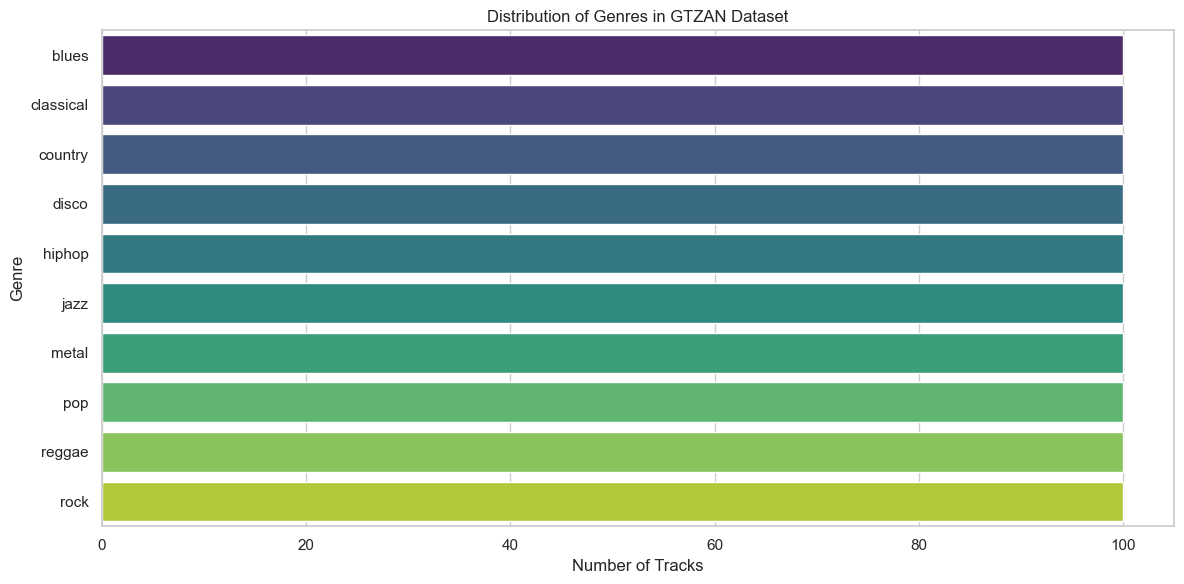


Genre Counts:
genre
blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: count, dtype: int64


In [4]:
# --- Genre Distribution Visualization ---
plt.figure(figsize=(12, 6))
sns.countplot(data=data_df, y='genre', order=data_df['genre'].value_counts().index, palette='viridis')
plt.title('Distribution of Genres in GTZAN Dataset')
plt.xlabel('Number of Tracks')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

print("\nGenre Counts:")
print(data_df['genre'].value_counts())
# GTZAN is known to be balanced (100 tracks per genre), this confirms it.


Visualizing Waveforms for Sample Tracks:


c:\ProgramData\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


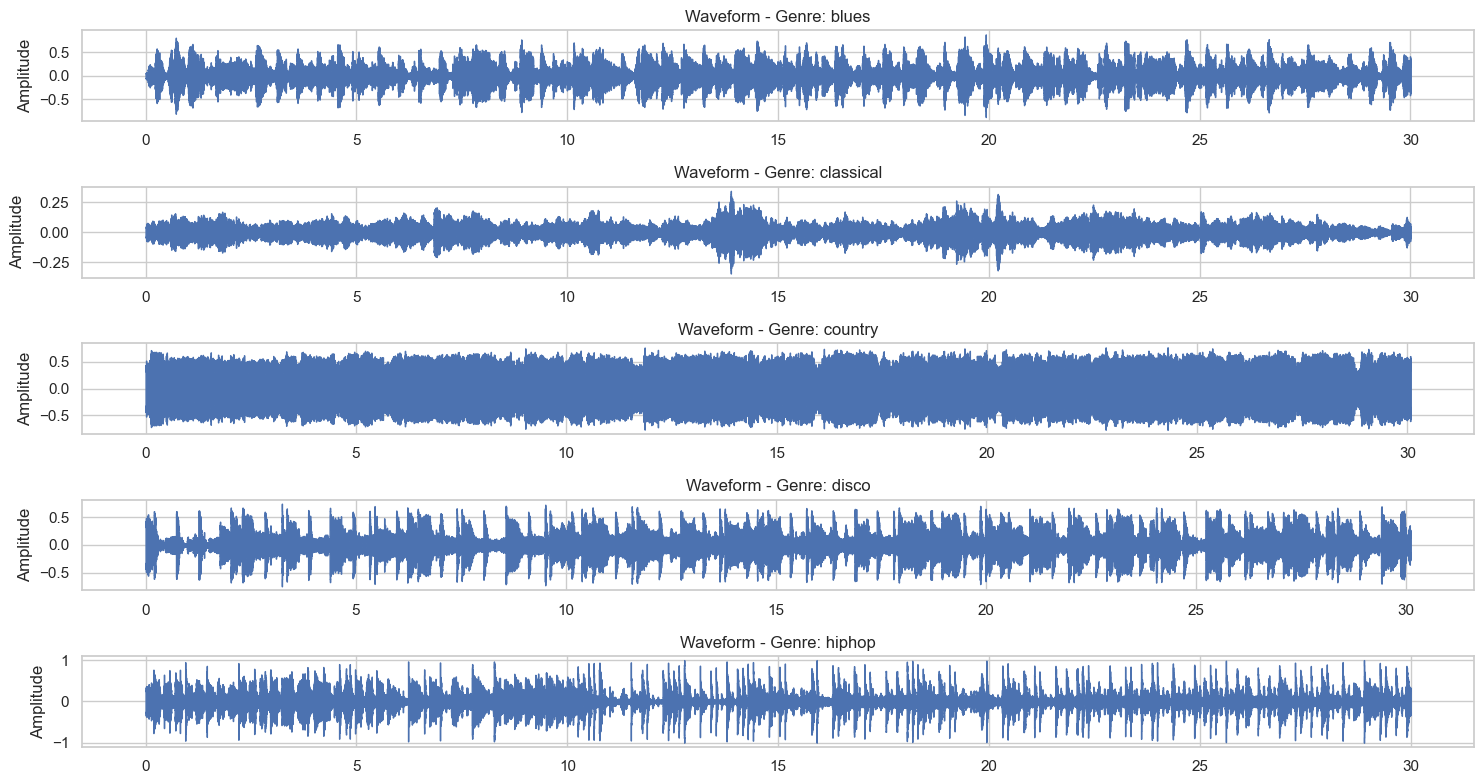

In [5]:
# --- Waveform Visualization ---
print("\nVisualizing Waveforms for Sample Tracks:")
num_genres_to_show = 5
genres_to_show = list(genre_mapping.values())[:num_genres_to_show] # Show first 5 genres

plt.figure(figsize=(15, 8))
for i, genre_name in enumerate(genres_to_show):
    # Find a sample file for this genre
    sample_file = data_df[data_df['genre'] == genre_name]['file_path'].iloc[0]
    try:
        y, sr = librosa.load(sample_file, sr=SAMPLE_RATE)
        plt.subplot(num_genres_to_show, 1, i + 1)
        librosa.display.waveshow(y, sr=sr)
        plt.title(f'Waveform - Genre: {genre_name}')
        plt.xlabel(None) # Remove x-label for intermediate plots
        plt.ylabel('Amplitude')
    except Exception as e:
        print(f"Could not load or plot {sample_file}: {e}")

plt.tight_layout()
plt.show()


Visualizing Mel-Spectrograms for Sample Tracks:


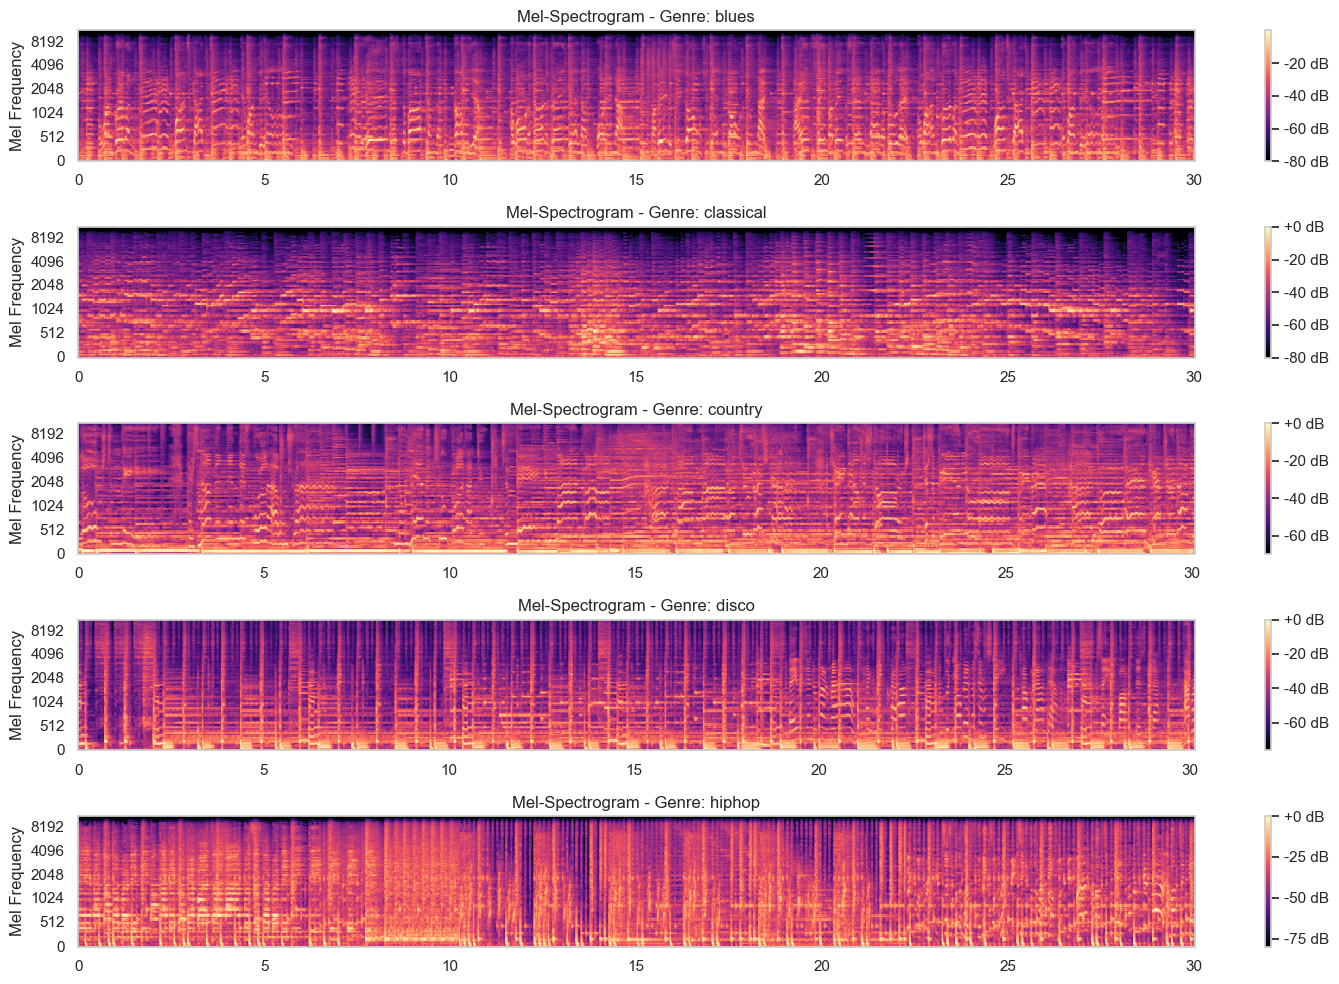

In [6]:
# --- Mel-Spectrogram Visualization ---
print("\nVisualizing Mel-Spectrograms for Sample Tracks:")

plt.figure(figsize=(15, 10)) # Adjust size for better layout
for i, genre_name in enumerate(genres_to_show):
    sample_file = data_df[data_df['genre'] == genre_name]['file_path'].iloc[0]
    try:
        y, sr = librosa.load(sample_file, sr=SAMPLE_RATE)
        # Calculate Mel-Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
        # Convert to dB (log scale)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        plt.subplot(num_genres_to_show, 1, i + 1)
        librosa.display.specshow(log_mel_spec, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel-Spectrogram - Genre: {genre_name}')
        plt.xlabel(None)
        plt.ylabel('Mel Frequency')
    except Exception as e:
        print(f"Could not process or plot spectrogram for {sample_file}: {e}")

plt.tight_layout()
plt.show()

Feature file 'processed_features_mel_spec_notebook.npz' not found. Extracting features...
Starting feature extraction... Expected samples/segment: 66150, Expected Mel vectors/segment: 130
  Processing file 50/1000: blues.00049.wav
  Processing file 100/1000: blues.00099.wav
  Processing file 150/1000: classical.00049.wav
  Processing file 200/1000: classical.00099.wav
  Processing file 250/1000: country.00049.wav
  Processing file 300/1000: country.00099.wav
  Processing file 350/1000: disco.00049.wav
  Processing file 400/1000: disco.00099.wav
  Processing file 450/1000: hiphop.00049.wav
  Processing file 500/1000: hiphop.00099.wav
  Processing file 550/1000: jazz.00049.wav
  Error processing jazz.00054.wav: 


C:\Users\FAST.LAB12-PC11\AppData\Local\Temp\ipykernel_10984\4216042434.py:16: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, current_sr = librosa.load(file_path, sr=sr)
C:\Users\FAST.LAB12-PC11\AppData\Roaming\Python\Python312\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Processing file 600/1000: jazz.00099.wav
  Processing file 650/1000: metal.00049.wav
  Processing file 700/1000: metal.00099.wav
  Processing file 750/1000: pop.00049.wav
  Processing file 800/1000: pop.00099.wav
  Processing file 850/1000: reggae.00049.wav
  Processing file 900/1000: reggae.00099.wav
  Processing file 950/1000: rock.00049.wav
  Processing file 1000/1000: rock.00099.wav

Feature extraction finished in 42.24 seconds.
Total segments processed: 9981
Features and labels saved to processed_features_mel_spec_notebook.npz


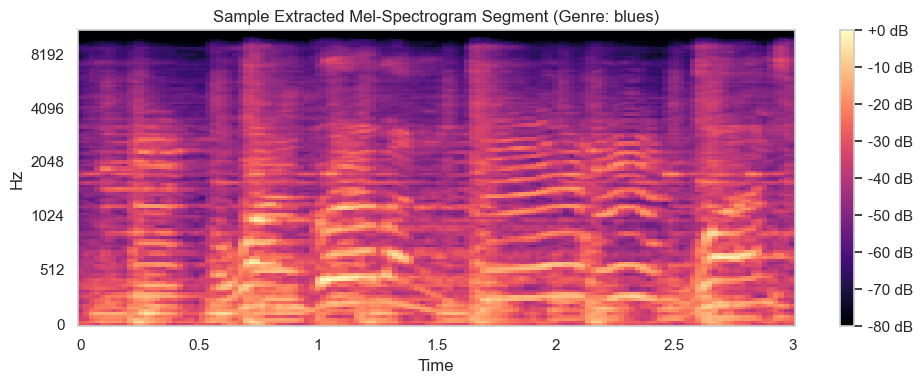

In [7]:
# --- Feature Extraction Function ---
def extract_features(file_paths, labels_int, sr, n_mels, n_fft, hop_length, segment_duration, num_segments_per_track):
    """Extracts Mel-Spectrogram features from audio files and segments them."""
    start_time = time.time()
    processed_features = []
    processed_labels = []

    samples_per_segment = int(sr * segment_duration)
    num_expected_vectors_per_segment = math.ceil(samples_per_segment / hop_length) # Expected time steps
    print(f"Starting feature extraction... Expected samples/segment: {samples_per_segment}, Expected Mel vectors/segment: {num_expected_vectors_per_segment}")

    for i, file_path in enumerate(file_paths):
        if (i + 1) % 50 == 0: # Print progress
             print(f"  Processing file {i+1}/{len(file_paths)}: {os.path.basename(file_path)}")
        try:
            signal, current_sr = librosa.load(file_path, sr=sr)

            # Ensure track is long enough for at least one full segment (robustness)
            if len(signal) < samples_per_segment:
                 print(f"  Warning: Skipping {os.path.basename(file_path)} (shorter than one segment: {len(signal)} < {samples_per_segment})")
                 continue

            # Process segments
            for s in range(num_segments_per_track):
                start_sample = s * samples_per_segment
                finish_sample = start_sample + samples_per_segment

                # Check boundary conditions
                if finish_sample > len(signal):
                     # print(f"    Segment {s+1} exceeds track length for {os.path.basename(file_path)}. Skipping remaining.")
                     break # Stop processing segments for this file if out of bounds

                audio_segment = signal[start_sample:finish_sample]

                # Extract Mel-Spectrogram
                mel_spec = librosa.feature.melspectrogram(y=audio_segment, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
                log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

                # Ensure fixed shape
                if log_mel_spec.shape == (n_mels, num_expected_vectors_per_segment):
                    processed_features.append(log_mel_spec)
                    processed_labels.append(labels_int[i]) # Assign original track's label to the segment
                else:
                    # Handle potential minor shape mismatches due to rounding/edge effects
                    # Common fix: Pad or truncate along the time axis (axis=1)
                    if log_mel_spec.shape[1] > num_expected_vectors_per_segment:
                        log_mel_spec = log_mel_spec[:, :num_expected_vectors_per_segment]
                    elif log_mel_spec.shape[1] < num_expected_vectors_per_segment:
                        pad_width = num_expected_vectors_per_segment - log_mel_spec.shape[1]
                        log_mel_spec = np.pad(log_mel_spec, pad_width=((0, 0), (0, pad_width)), mode='constant')
                    
                    if log_mel_spec.shape == (n_mels, num_expected_vectors_per_segment):
                        processed_features.append(log_mel_spec)
                        processed_labels.append(labels_int[i])
                    # else: # Still mismatched after padding/truncation? Skip.
                    #     print(f"  Warning: Segment {s+1} in {os.path.basename(file_path)} has incorrect shape {log_mel_spec.shape} even after fix. Skipping.")

        except Exception as e:
            print(f"  Error processing {os.path.basename(file_path)}: {e}")

    end_time = time.time()
    print(f"\nFeature extraction finished in {end_time - start_time:.2f} seconds.")
    print(f"Total segments processed: {len(processed_features)}")

    if not processed_features:
        raise ValueError("No features were extracted.")

    return np.array(processed_features), np.array(processed_labels)


# --- Execute Feature Extraction (if file doesn't exist) ---
if not os.path.exists(FEATURES_PATH):
    print(f"Feature file '{FEATURES_PATH}' not found. Extracting features...")
    try:
        X_features, y_labels = extract_features(
            data_df['file_path'].tolist(),
            data_df['label_int'].tolist(),
            SAMPLE_RATE, N_MELS, N_FFT, HOP_LENGTH, SEGMENT_DURATION, NUM_SEGMENTS_PER_TRACK
        )
        # Save features and labels
        np.savez(FEATURES_PATH, features=X_features, labels=y_labels)
        print(f"Features and labels saved to {FEATURES_PATH}")
    except ValueError as e:
        print(f"Error during feature extraction: {e}")
        raise SystemExit("Stopping execution due to feature extraction error.")
    except Exception as e:
        print(f"An unexpected error occurred during feature extraction: {e}")
        raise SystemExit("Stopping execution due to unexpected feature extraction error.")

else:
    print(f"Loading features from {FEATURES_PATH}...")
    try:
        data = np.load(FEATURES_PATH)
        X_features = data['features']
        y_labels = data['labels']
        print(f"Features loaded successfully. Shape: {X_features.shape}, Labels shape: {y_labels.shape}")
        if X_features.size == 0 or y_labels.size == 0:
             raise ValueError("Loaded features or labels are empty.")
    except Exception as e:
        print(f"Error loading features from {FEATURES_PATH}: {e}")
        raise SystemExit("Stopping execution due to feature loading error.")

# --- Visualize a Sample Extracted Feature ---
if X_features.size > 0:
    plt.figure(figsize=(10, 4))
    sample_feature_index = 0 # Visualize the first extracted segment
    librosa.display.specshow(X_features[sample_feature_index], sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    original_label_int = y_labels[sample_feature_index]
    original_genre = genre_mapping.get(original_label_int, "Unknown")
    plt.title(f'Sample Extracted Mel-Spectrogram Segment (Genre: {original_genre})')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping feature visualization as no features were loaded/extracted.")

In [8]:
# --- Data Augmentation Functions (Demonstration) ---
def add_noise(audio_segment, noise_factor=0.005):
    noise = np.random.randn(len(audio_segment))
    augmented_audio = audio_segment + noise_factor * noise
    # Cast back to same data type and clip range
    augmented_audio = augmented_audio.astype(type(audio_segment[0]))
    return augmented_audio

def time_stretch(audio_segment, rate=1.0): # rate > 1 speeds up, < 1 slows down
    if rate == 1.0: return audio_segment
    return librosa.effects.time_stretch(y=audio_segment, rate=rate)

def pitch_shift(audio_segment, sr, n_steps=0): # n_steps = number of semitones
    if n_steps == 0 : return audio_segment
    return librosa.effects.pitch_shift(y=audio_segment, sr=sr, n_steps=n_steps)

# Example: How you *might* apply augmentation conceptually before feature extraction
# (Not run here, integrated into extract_features or a data generator usually)
# if is_training_data and random.random() < 0.5: # Apply randomly
#     aug_type = random.choice(['noise', 'pitch', 'stretch'])
#     if aug_type == 'noise':
#         audio_segment = add_noise(audio_segment, noise_factor=0.005)
#     # ... other augmentations ...
#     # Then extract features from the augmented_audio_segment


Splitting data into Training, Validation, and Test sets...
Training set shape: (6986, 128, 130), Labels: (6986,)
Validation set shape: (1497, 128, 130), Labels: (1497,)
Test set shape: (1498, 128, 130), Labels: (1498,)
Input shape for CNN: (128, 130, 1)
Labels successfully one-hot encoded. Example shape: (6986, 10)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 130, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 130, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 65, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 65, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 33, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 33, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 33, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 33, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 34816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,456,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,551,946 (17.36 MB)

 Trainable params: 4,551,242 (17.36 MB)

 Non-trainable params: 704 (2.75 KB)


Starting model training...
Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.3272 - loss: 2.2374
Epoch 1: val_accuracy improved from -inf to 0.40949, saving model to music_genre_cnn_mel_spec_notebook.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 36s 159ms/step - accuracy: 0.3276 - loss: 2.2356 - val_accuracy: 0.4095 - val_loss: 1.7926
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.5493 - loss: 1.3082
Epoch 2: val_accuracy improved from 0.40949 to 0.54108, saving model to music_genre_cnn_mel_spec_notebook.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 36s 165ms/step - accuracy: 0.5494 - loss: 1.3080 - val_accuracy: 0.5411 - val_loss: 1.4834
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6243 - loss: 1.0901
Epoch 3: val_accuracy improved from 0.54108 to 0.60254, saving model to music_genre_cnn_mel_spec_notebook.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 38s 172ms/step - accuracy: 0.6244 - loss: 1.0899 - val_accuracy: 0.6025 - val_loss: 1.1658
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6784 - loss: 0.9375
Epoch 4: val_accuracy did not improve from 0.60254
219/219 ━━━━━━━━━━━━━━━━━━━━ 37s 168ms/step - accuracy: 0.6785 - loss: 0.9374 - val_accuracy: 0.5765 - val_loss: 1.2396
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7261 - loss: 0.8349
Epoch 5: val_accuracy did not improve from 0.60254
219/219 ━━━━━━━━━━━━━━━━━━━━ 37s 170ms/step - accuracy: 0.7261 - loss: 0.8348 - val_accuracy: 0.5992 - val_loss: 1.1620
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7589 - loss: 0.7202
Epoch 6: val_accuracy improved from 0.60254 to 0.65731, saving model to music_genre_cnn_mel_spec_notebook.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 37s 167ms/step - accuracy: 0.7589 - loss: 0.7202 - val_accuracy: 0.6573 - val_loss: 1.0203
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.7838 - loss: 0.6342
Epoch 7: val_accuracy improved from 0.65731 to 0.69405, saving model to music_genre_cnn_mel_spec_notebook.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 37s 170ms/step - accuracy: 0.7839 - loss: 0.6342 - val_accuracy: 0.6941 - val_loss: 0.9474
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8070 - loss: 0.5655
Epoch 8: val_accuracy did not improve from 0.69405
219/219 ━━━━━━━━━━━━━━━━━━━━ 37s 170ms/step - accuracy: 0.8070 - loss: 0.5655 - val_accuracy: 0.6934 - val_loss: 0.9095
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8351 - loss: 0.5021
Epoch 9: val_accuracy did not improve from 0.69405
219/219 ━━━━━━━━━━━━━━━━━━━━ 36s 166ms/step - accuracy: 0.8350 - loss: 0.5022 - val_accuracy: 0.6393 - val_loss: 1.0672
Epoch 10/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8524 - loss: 0.4557
Epoch 10: val_accuracy improved from 0.69405 to 0.69940, saving model to music_genre_cnn_mel_spec_notebook.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 37s 169ms/step - accuracy: 0.8524 - loss: 0.4558 - val_accuracy: 0.6994 - val_loss: 0.8779
Restoring model weights from the end of the best epoch: 10.

Training finished in 368.48 seconds.


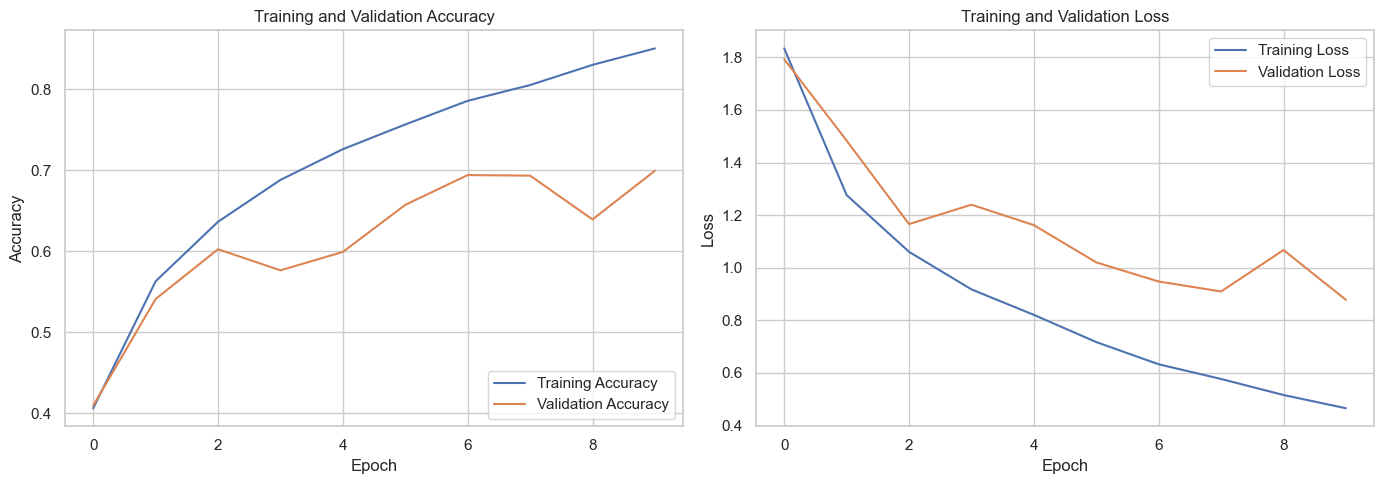


Evaluating model on the Test Set using the best saved weights...



Test Set Evaluation Results:
  Test Loss: 0.9445
  Test Accuracy: 0.6836 (68.36%)


In [9]:
# --- Data Splitting ---
print("\nSplitting data into Training, Validation, and Test sets...")
# Stratify ensures proportional representation of each genre in splits
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_labels, test_size=TEST_SIZE, random_state=42, stratify=y_labels
)
# Further split training into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=VALIDATION_SIZE / (1 - TEST_SIZE), random_state=42, stratify=y_train
)

print(f"Training set shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test set shape: {X_test.shape}, Labels: {y_test.shape}")

# --- Data Preparation for CNN ---
# Add channel dimension (CNN expects [batch, height, width, channels])
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]
input_shape = X_train.shape[1:] # Shape of one sample (height, width, channels)
num_genres = len(genre_mapping)
print(f"Input shape for CNN: {input_shape}")

# --- Optional: Scaling Features ---
# Although Batch Normalization helps, scaling inputs can sometimes still be beneficial.
# If using StandardScaler:
# scaler = StandardScaler()
# # Reshape for scaler: (num_samples * height * width, channels) -> fit -> reshape back
# # Fit ONLY on training data
# train_h, train_w, train_c = X_train.shape[1], X_train.shape[2], X_train.shape[3]
# X_train_reshaped = X_train.reshape(-1, train_c)
# scaler.fit(X_train_reshaped)
# # Transform all sets
# X_train = scaler.transform(X_train.reshape(-1, train_c)).reshape(-1, train_h, train_w, train_c)
# X_val = scaler.transform(X_val.reshape(-1, train_c)).reshape(-1, train_h, train_w, train_c)
# X_test = scaler.transform(X_test.reshape(-1, train_c)).reshape(-1, train_h, train_w, train_c)
# # Save the scaler
# with open(SCALER_PATH, 'wb') as f:
#     pickle.dump(scaler, f)
# print("Features scaled using StandardScaler.")


# --- One-Hot Encode Labels ---
# Using tf.keras.utils.to_categorical
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=num_genres)
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=num_genres)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=num_genres)
print(f"Labels successfully one-hot encoded. Example shape: {y_train_one_hot.shape}")


# --- Build CNN Model Function ---
def build_cnn_model(input_shape, num_classes, learning_rate):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),

        # Conv Block 1
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
        tf.keras.layers.Dropout(0.25), # Added dropout after pooling

        # Conv Block 2
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
        tf.keras.layers.Dropout(0.25),

        # Conv Block 3
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
        tf.keras.layers.Dropout(0.3),

        # Flatten and Dense Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'), # Increased dense layer size slightly
        tf.keras.layers.BatchNormalization(), # Added BN here too
        tf.keras.layers.Dropout(0.5), # Increased dropout before final layer
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary() # Print model architecture
    return model

# --- Instantiate and Compile the Model ---
model = build_cnn_model(input_shape, num_genres, LEARNING_RATE)

# --- Train the Model ---
print("\nStarting model training...")
# Callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    MODEL_SAVE_PATH, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=1, restore_best_weights=True # Stop if val_loss doesn't improve for 10 epochs
)

# Record training time
training_start_time = time.time()

history = model.fit(
    X_train, y_train_one_hot,
    validation_data=(X_val, y_val_one_hot),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_callback, early_stopping_callback],
    verbose=1 # Set to 1 or 2 for progress updates, 0 for silent
)

training_end_time = time.time()
print(f"\nTraining finished in {training_end_time - training_start_time:.2f} seconds.")

# --- Plot Training History ---
def plot_training_history(history):
    """Plots accuracy and loss curves for training and validation sets."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc)) # Use actual number of epochs run

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# --- Evaluate on Test Set ---
print("\nEvaluating model on the Test Set using the best saved weights...")
# Load the best model saved during training
try:
    best_model = tf.keras.models.load_model(MODEL_SAVE_PATH)
    test_loss, test_accuracy = best_model.evaluate(X_test, y_test_one_hot, verbose=0)
    print(f"\nTest Set Evaluation Results:")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
except Exception as e:
    print(f"Error loading or evaluating the best model from {MODEL_SAVE_PATH}: {e}")
    best_model = None # Ensure variable exists but indicates failure

In [10]:
# --- Discussion on Tuning (No Code Execution Here) ---
print("\n--- Hyperparameter Tuning Discussion ---")
print(f"The current model was trained with:")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs (max): {EPOCHS} (Early stopping may have occurred)")
print(f"  Architecture: As defined in build_cnn_model()")
print("\nTo potentially improve performance, further hyperparameter tuning could involve:")
print("  - Adjusting the Learning Rate (e.g., using a learning rate scheduler).")
print("  - Trying different Batch Sizes (e.g., 16, 64, 128).")
print("  - Modifying Dropout rates or adding/removing layers in the CNN.")
print("  - Experimenting with different optimizers (e.g., RMSprop).")
print("  - Using tools like KerasTuner for automated search.")
print("The validation set accuracy/loss curves from the training plot provide guidance for manual tuning.")


--- Hyperparameter Tuning Discussion ---
The current model was trained with:
  Learning Rate: 0.0001
  Batch Size: 32
  Epochs (max): 10 (Early stopping may have occurred)
  Architecture: As defined in build_cnn_model()

To potentially improve performance, further hyperparameter tuning could involve:
  - Adjusting the Learning Rate (e.g., using a learning rate scheduler).
  - Trying different Batch Sizes (e.g., 16, 64, 128).
  - Modifying Dropout rates or adding/removing layers in the CNN.
  - Experimenting with different optimizers (e.g., RMSprop).
  - Using tools like KerasTuner for automated search.
The validation set accuracy/loss curves from the training plot provide guidance for manual tuning.



Generating predictions on the test set...
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

Classification Report (Test Set):
              precision    recall  f1-score   support

       blues      0.929     0.087     0.159       150
   classical      0.827     0.927     0.874       150
     country      0.881     0.347     0.498       150
       disco      0.815     0.647     0.721       150
      hiphop      0.729     0.913     0.811       150
        jazz      0.696     0.804     0.746       148
       metal      0.915     0.867     0.890       150
         pop      0.781     0.833     0.806       150
      reggae      0.929     0.520     0.667       150
        rock      0.341     0.893     0.494       150

    accuracy                          0.684      1498
   macro avg      0.784     0.684     0.667      1498
weighted avg      0.784     0.684     0.666      1498


Confusion Matrix (Test Set):


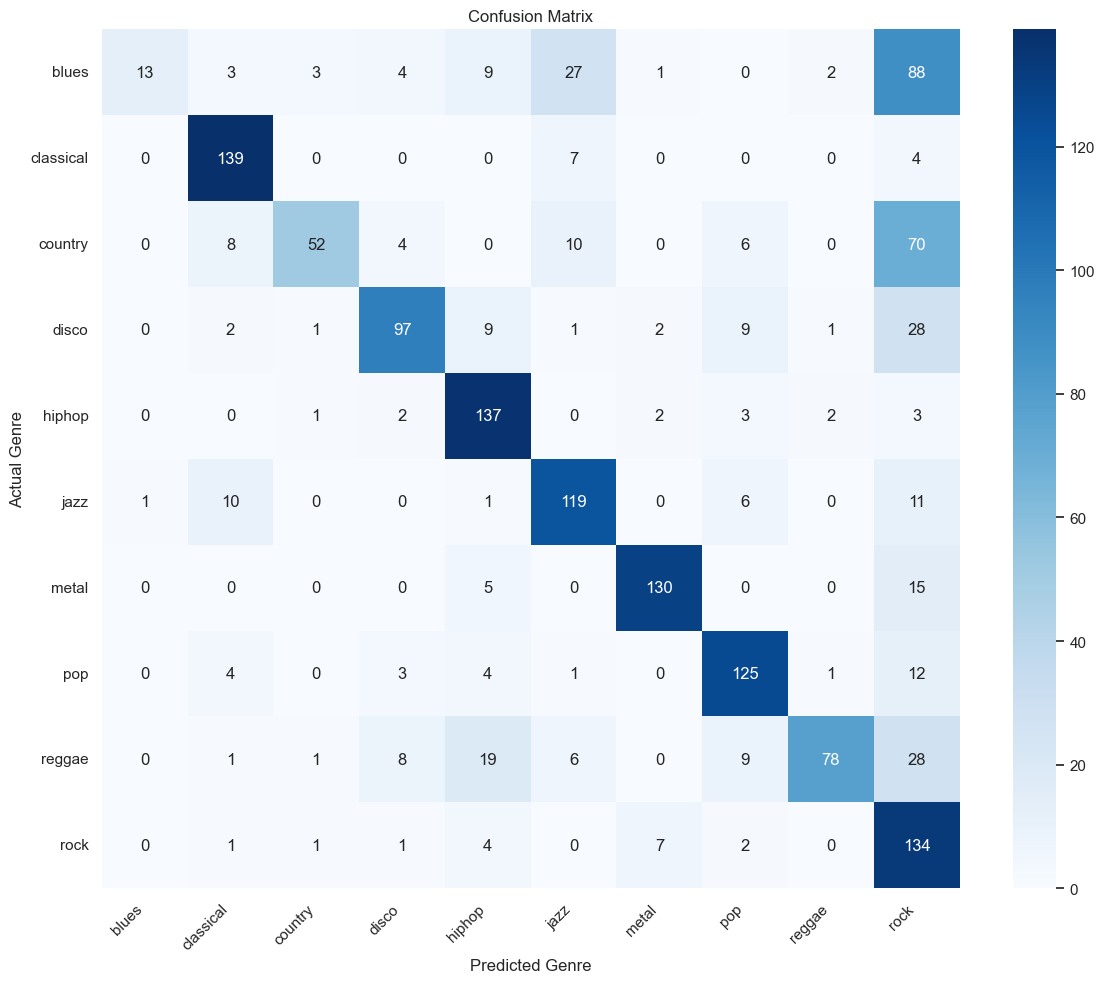


--- Report Summary ---
Overall Test Accuracy: 68.36%

Interpretation:
- The Classification Report shows precision, recall, and F1-score for each genre.
  - High scores indicate good performance for that specific genre.
  - Look for genres with lower scores, indicating areas where the model struggles.
- The Confusion Matrix visualizes these struggles:
  - Numbers on the diagonal represent correct predictions.
  - Off-diagonal numbers show misclassifications (e.g., cell [i, j] shows how many times actual genre 'i' was predicted as genre 'j').
  - Common confusions (large off-diagonal numbers) might suggest acoustically similar genres or areas for model improvement.

Addressing Research Questions (Based on this run):
  - RQ1 (CNN Effectiveness): The achieved accuracy (68.36%) and per-class metrics demonstrate the CNN's capability on this task using Mel-Spectrograms. Performance varies by genre.
  - RQ2 (Augmentation): Augmentation was discussed but not explicitly applied in this training

In [11]:
# --- Generate Predictions on Test Set ---
if best_model:
    print("\nGenerating predictions on the test set...")
    y_pred_probs = best_model.predict(X_test)
    y_pred_labels = np.argmax(y_pred_probs, axis=1) # Get the index of the highest probability

    # --- Classification Report ---
    print("\nClassification Report (Test Set):")
    # Get genre names for the report
    target_names = [genre_mapping.get(i, f"Unknown_{i}") for i in range(num_genres)]
    try:
         report = classification_report(y_test, y_pred_labels, target_names=target_names, digits=3)
         print(report)
    except ValueError as e:
         print(f"Could not generate classification report. Check if all labels are present. Error: {e}")
         print("Unique true labels in y_test:", np.unique(y_test))
         print("Unique predicted labels:", np.unique(y_pred_labels))


    # --- Confusion Matrix ---
    print("\nConfusion Matrix (Test Set):")
    cm = confusion_matrix(y_test, y_pred_labels)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Genre')
    plt.xlabel('Predicted Genre')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print("\nSkipping final evaluation metrics as the model was not loaded/trained successfully.")

# --- Final Report Summary (Textual Interpretation) ---
print("\n--- Report Summary ---")
if best_model:
    print(f"Overall Test Accuracy: {test_accuracy*100:.2f}%")
    print("\nInterpretation:")
    print("- The Classification Report shows precision, recall, and F1-score for each genre.")
    print("  - High scores indicate good performance for that specific genre.")
    print("  - Look for genres with lower scores, indicating areas where the model struggles.")
    print("- The Confusion Matrix visualizes these struggles:")
    print("  - Numbers on the diagonal represent correct predictions.")
    print("  - Off-diagonal numbers show misclassifications (e.g., cell [i, j] shows how many times actual genre 'i' was predicted as genre 'j').")
    print("  - Common confusions (large off-diagonal numbers) might suggest acoustically similar genres or areas for model improvement.")
    print("\nAddressing Research Questions (Based on this run):")
    print(f"  - RQ1 (CNN Effectiveness): The achieved accuracy ({test_accuracy*100:.2f}%) and per-class metrics demonstrate the CNN's capability on this task using Mel-Spectrograms. Performance varies by genre.")
    print(f"  - RQ2 (Augmentation): Augmentation was discussed but not explicitly applied in this training run. Comparing runs with/without augmentation would quantify its impact on robustness.")
    print(f"  - RQ3 (Optimization): This run used fixed hyperparameters. Further tuning (as discussed in Step 5) could potentially improve these results.")
    print(f"  - RQ4 (Dataset Challenges): GTZAN is relatively clean and balanced. Challenges observed might include confusions between similar genres (e.g., Rock/Metal, Classical/Jazz nuances). Handling larger, noisier, or imbalanced datasets would require different strategies (more augmentation, class weighting, etc.).")
else:
    print("Model evaluation could not be completed.")

print("\n--- End of Notebook Execution ---")